In [1]:
from pathlib import Path

import numpy as np
import qcportal  # noqa avoid zstd disaster
from openff.units import unit
from openff.qcsubmit import workflow_components
from openff.qcsubmit.factories import OptimizationDatasetFactory
from openff.toolkit import ForceField, Molecule
from tqdm import tqdm

In [2]:
# initialize dataset factory
dataset_factory = OptimizationDatasetFactory()
dataset_factory.add_workflow_components(
    workflow_components.StandardConformerGenerator(
        max_conformers=10, rms_cutoff=0.5
    )
)

In [3]:
# load mols

smi_files = sorted(Path("inputs").glob("*.smi"))
molecules = []
for smi_file in smi_files:
    molecules.extend(
        Molecule.from_file(smi_file, "SMI", allow_undefined_stereo=True)
    )

print(len(molecules))

70


In [4]:
description = """\
Molecules contributed by Cresset to address lack of data coverage for particular torsion drives.
These molecules are contributed to address five failure cases:

1) Sage 2.1 t48a is fit only to one molecule,
where the complementary torsion contributes most of the profile

2) Sage 2.1 t17 may benefit from splitting and a different shape for non-symmetric rings;
the current n=3 shape sums to a constant

3) Sage 2.1 t19 is mostly trained to terminal methyls.
It has a functional form where the n=1 term dominates unexpectedly,
instead of the more expected equal n=3 contributions.
More data with non-terminal methyls is added

4) Sage 2.1 t18 covers amide-adjacent torsions but is not trained to many.

5) Sage 2.1 t105 covers an O linker with an sp2 or sp3 terminus.
While the sp3 profiles match the QM well, the sp2 profiles look too stiff.
This adds more data.
"""

dataset = dataset_factory.create_dataset(
    dataset_name="OpenFF Cresset Additional Coverage Optimizations v4.0",
    tagline="Additional optimizations for treating torsions with low coverage identified by Cresset",
    description=description,
    molecules=molecules,
)

Preparation                   : 100%|███████████| 70/70 [00:01<00:00, 40.80it/s]


In [5]:
n_confs = np.array(
    [mol.n_conformers for mol in dataset.molecules]
)

n_heavy_atoms = np.array(
    [mol.to_rdkit().GetNumHeavyAtoms() for mol in dataset.molecules]
)

masses = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in dataset.molecules
])

elements = set(
    atom.symbol
    for mol in dataset.molecules
    for atom in mol.atoms
)

unique_charges = [str(charge) for charge in sorted(set([
    mol.total_charge.m_as(unit.elementary_charge)
    for mol in dataset.molecules
]))]

from collections import Counter

print("# heavy atoms")
counts = Counter(n_heavy_atoms)
for n_heavy in sorted(counts):
    print(f"{str(n_heavy):>3}: {counts[n_heavy]}")


# heavy atoms
  4: 1
  5: 1
  6: 5
  7: 5
  8: 8
  9: 13
 10: 7
 11: 9
 12: 8
 13: 6
 14: 2
 15: 1
 16: 2
 17: 1
 19: 1


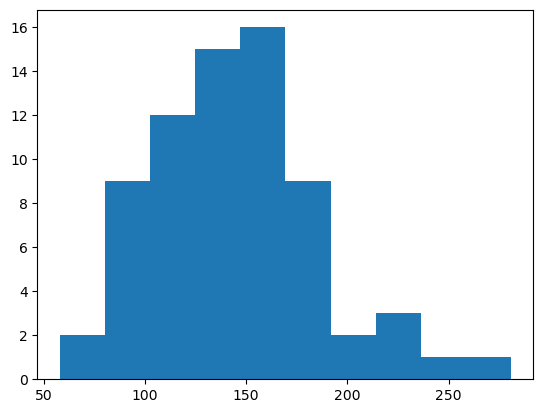

In [6]:
from matplotlib import pyplot as plt
plt.figure()
plt.hist(masses)
plt.show()

In [7]:
print('* Name: {}'.format(dataset.dataset_name))
print('* Number of unique molecules: {}'.format(dataset.n_molecules))
print('* Number of conformers: {}'.format(dataset.n_records))
print('* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(n_confs),np.mean(n_confs),max(n_confs)))
print('* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(masses),np.mean(masses),max(masses)))
print('* Charges: {}'.format(' '.join(unique_charges)))

print("## Metadata")
print(f"* Elements: {{{', '.join(dataset.metadata.dict()['elements'])}}}")

def print_field(od, field): print(f"  * {field}: {od[field]}")

fields = ["basis", "implicit_solvent", "keywords", "maxiter", "method", "program"]
for spec, obj in dataset.qc_specifications.items():
    od = obj.dict()
    print("* Spec:", spec)
    for field in fields:
        print_field(od, field)
    print("  * SCF properties:")
    for field in od["scf_properties"]:
        print(f"    * {field}")

* Name: OpenFF Cresset Additional Coverage Optimizations v4.0
* Number of unique molecules: 70
* Number of conformers: 393
* Number of conformers (min, mean, max): 1.00, 5.61, 10.00
* Molecular weight (min, mean, max): 58.08, 144.98, 280.75
* Charges: -1.0 0.0 1.0
## Metadata
* Elements: {O, C, F, S, H, N, Br, Cl}
* Spec: default
  * basis: DZVP
  * implicit_solvent: None
  * keywords: {}
  * maxiter: 200
  * method: B3LYP-D3BJ
  * program: psi4
  * SCF properties:
    * dipole
    * quadrupole
    * wiberg_lowdin_indices
    * mayer_indices
